In [22]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt


def graph(lines):
    codebert_metrics = {
        'exact_match': [],
        'variable_names': [],
        'variable_values': [],
        'strings': [],
        'comments': [],
        'total_match': []
    }

    codet5_metrics = {
        'exact_match': [],
        'variable_names': [],
        'variable_values': [],
        'strings': [],
        'comments': [],
        'total_match': []
    }

    # Define a function to extract metrics from a block of text
    def extract_metrics(lines, model):
        metrics = {
            'exact_match': None,
            'variable_names': None,
            'variable_values': None,
            'strings': None,
            'comments': None,
            'total_match': None
        }
        
        exact_match_count = 0
        
        for line in lines:
            if 'exact match' in line:
                if model == 'T5' and exact_match_count == 1:
                    metrics['total_match'] = float(re.findall(r'[\d.]+', line)[0])
                else:
                    metrics['exact_match'] = float(re.findall(r'[\d.]+', line)[0])
                    exact_match_count += 1
            elif 'variable_names' in line:
                metrics['variable_names'] = float(re.findall(r'[\d.]+', line)[0])
            elif 'variable_values' in line:
                metrics['variable_values'] = float(re.findall(r'[\d.]+', line)[0])
            elif 'strings' in line:
                metrics['strings'] = float(re.findall(r'[\d.]+', line)[0])
            elif 'comments' in line:
                metrics['comments'] = float(re.findall(r'[\d.]+', line)[0])
            elif 'total match' in line:
                metrics['total_match'] = float(re.findall(r'[\d.]+', line)[0])
        
        if model == 'codeBERT':
            for key in codebert_metrics:
                codebert_metrics[key].append(metrics[key])
        elif model == 'T5':
            for key in codet5_metrics:
                codet5_metrics[key].append(metrics[key])

    # Process the lines to extract metrics
    current_model = None
    block_lines = []

    for line in lines:
        if 'codeBERT:' in line:
            if current_model == 'T5':
                extract_metrics(block_lines, 'T5')
            current_model = 'codeBERT'
            block_lines = []
        elif 'T5:' in line:
            if current_model == 'codeBERT':
                extract_metrics(block_lines, 'codeBERT')
            current_model = 'T5'
            block_lines = []
        elif 'Extracting memorized content' in line:
            if current_model:
                extract_metrics(block_lines, current_model)
            current_model = None
            block_lines = []
        else:
            block_lines.append(line)

    # Ensure to extract the last block
    if current_model:
        extract_metrics(block_lines, current_model)

    # Convert lists to numpy arrays
    for key in codebert_metrics:
        codebert_metrics[key] = np.array(codebert_metrics[key])

    for key in codet5_metrics:
        codet5_metrics[key] = np.array(codet5_metrics[key])


    # Extract sample indices
    samples = np.arange(100, 100 * (len(codebert_metrics['exact_match']) + 1), 100)

    def calculate_individual_means(cumulative_means, values):
        individual_means = []
        total_values = 0
        previous_mean_sum = 0
        
        for i, (cum_mean, value_count) in enumerate(zip(cumulative_means, values)):
            total_values += value_count
            current_mean_sum = cum_mean * total_values
            individual_sum = current_mean_sum - previous_mean_sum
            individual_mean = individual_sum / value_count
            individual_means.append(individual_mean)
            previous_mean_sum = current_mean_sum
        
        return individual_means
    
    def create_comparison_plot_mean():
        mean = calculate_individual_means(codebert_metrics['exact_match'], codet5_metrics['total_match'])
        mean2 = calculate_individual_means(codet5_metrics['exact_match'], codet5_metrics['total_match'])
        # caclulate the standard deviation of mean and mean2
        std_dev_mean = np.std(mean)
        std_dev_mean2 = np.std(mean2)
        print(f"Standard Deviation of codeBERT: {std_dev_mean*100}")
        print(f"Standard Deviation of codeT5: {std_dev_mean2*100}")
        plt.figure(figsize=(10, 6))
        plt.plot(samples, mean, label='codeBERT', marker='o')
        plt.plot(samples, mean2, label='codeT5', marker='o')
        plt.xlabel('Number of Samples')
        plt.ylabel('Exact Match')
        plt.title('Comparison of Exact Match')
        plt.legend()
        plt.grid(True)
        plt.show()  

        
    # Define a function to create comparison plots
    def create_comparison_plot(metric_name):
        plt.figure(figsize=(10, 6))
        plt.plot(samples, codebert_metrics[metric_name], label='codeBERT', marker='o')
        plt.plot(samples, codet5_metrics[metric_name], label='codeT5', marker='o')
        plt.xlabel('Number of Samples')
        plt.ylabel(metric_name.replace('_', ' ').title())
        plt.title(f'Comparison of {metric_name.replace("_", " ").title()}')
        plt.legend()
        plt.grid(True)
        plt.show()

    def side_by_side_plot(metric_name):
        fig, ax = plt.subplots(1, 2, figsize=(15, 6))
        ax[0].plot(samples, codebert_metrics[metric_name], label='codeBERT', marker='o')
        ax[0].set_xlabel('Number of Samples')
        ax[0].set_ylabel(metric_name.replace('_', ' ').title())
        ax[0].set_title(f'codeBERT {metric_name.replace("_", " ").title()}')
        ax[0].legend()
        ax[0].grid(True)
        
        ax[1].plot(samples, codet5_metrics[metric_name], label='codeT5', marker='o')
        ax[1].set_xlabel('Number of Samples')
        ax[1].set_ylabel(metric_name.replace('_', ' ').title())
        ax[1].set_title(f'codeT5 {metric_name.replace("_", " ").title()}')
        ax[1].legend()
        ax[1].grid(True)
        
        plt.show()
    # Plot for each metric
    metrics = ['exact_match']
    #['exact_match', 'variable_names', 'variable_values', 'strings', 'comments']

    for metric in metrics:
        #create_comparison_plot(metric)
        side_by_side_plot(metric)
    #create_comparison_plot_mean()

In [23]:
import os

def get_files_with_type_starting_o(folder_path):
    files_with_o_type = []
    for file in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, file)):
            file_parts = file.split('.')
            if len(file_parts) > 1 and file_parts[-1].startswith('o'):
                files_with_o_type.append(file)
    return files_with_o_type

# Example usage
folder_path = r'C:\Users\vaiku\Downloads\results\bertandt5'
files = get_files_with_type_starting_o(folder_path)
print(files)


['java32.o44770211', 'java8.o44770225', 'javascript32.o44770292', 'javascript8.o44770236', 'python32.o44770109', 'python8.o44770208', 'ruby32.o44770279', 'ruby8.o44770278']


java32.o44770211


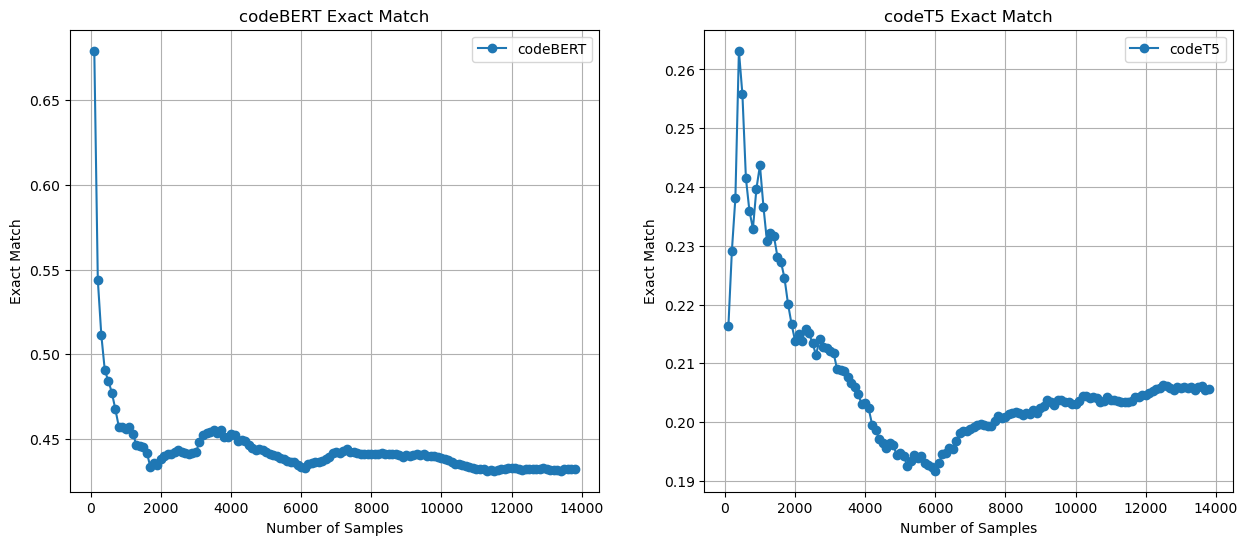

java8.o44770225


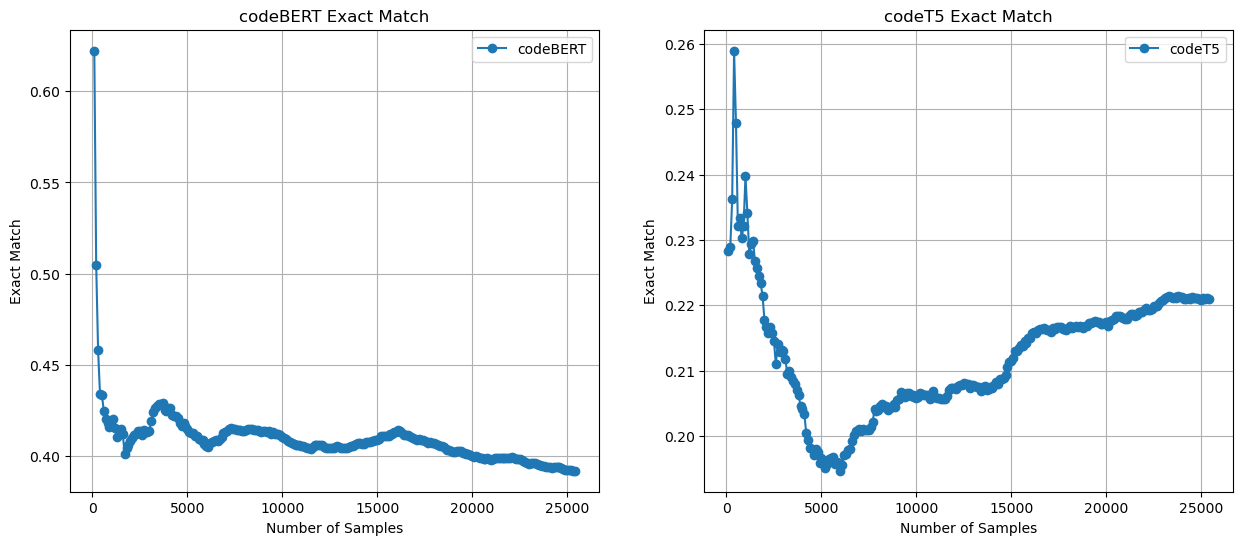

javascript32.o44770292


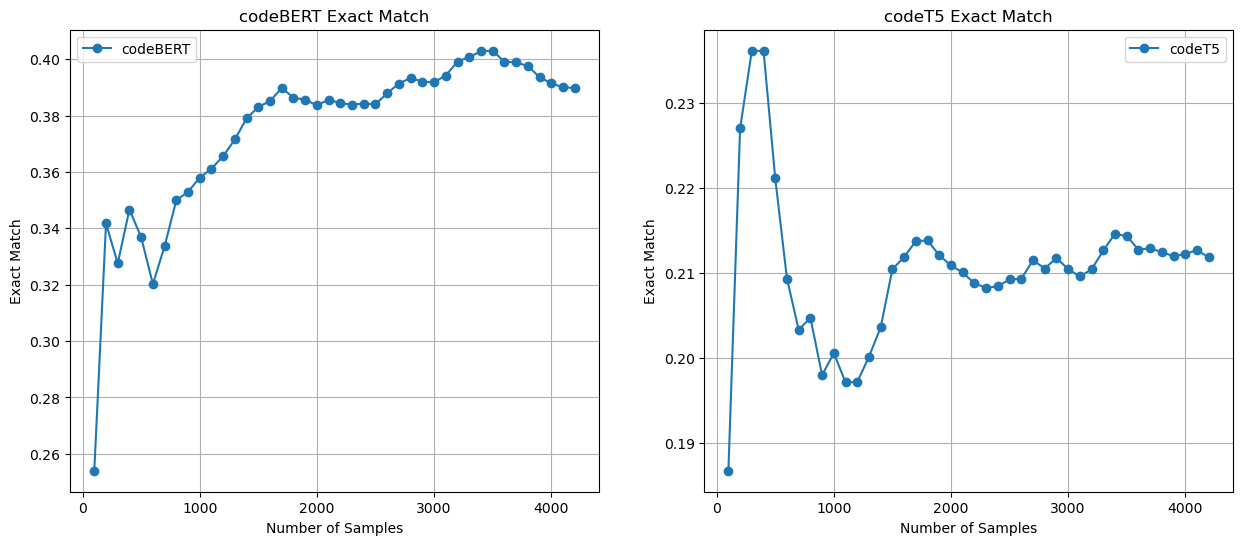

javascript8.o44770236


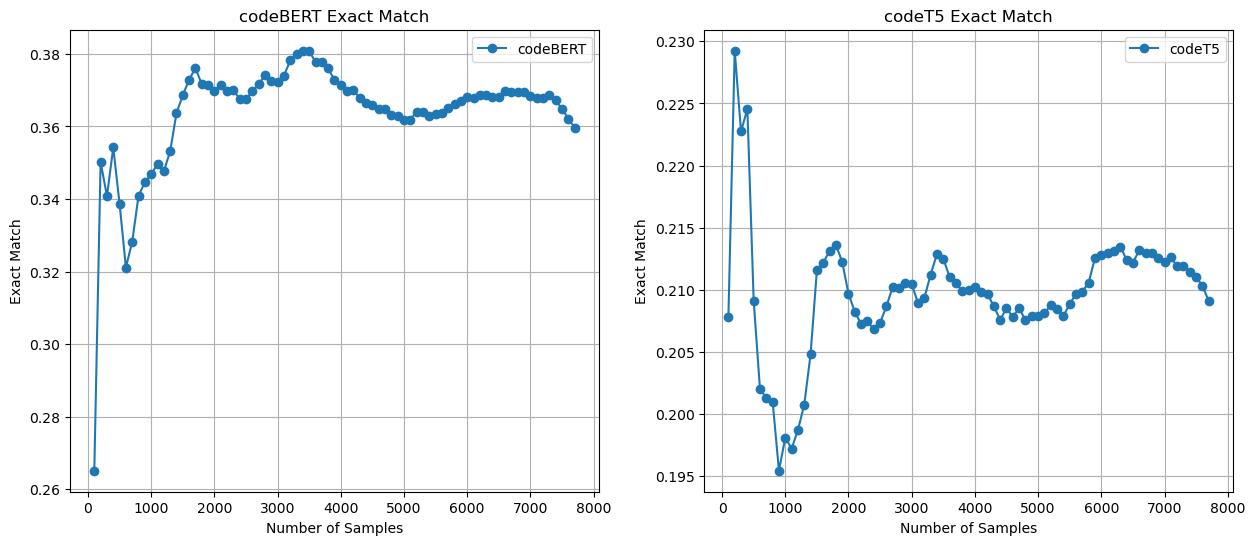

python32.o44770109


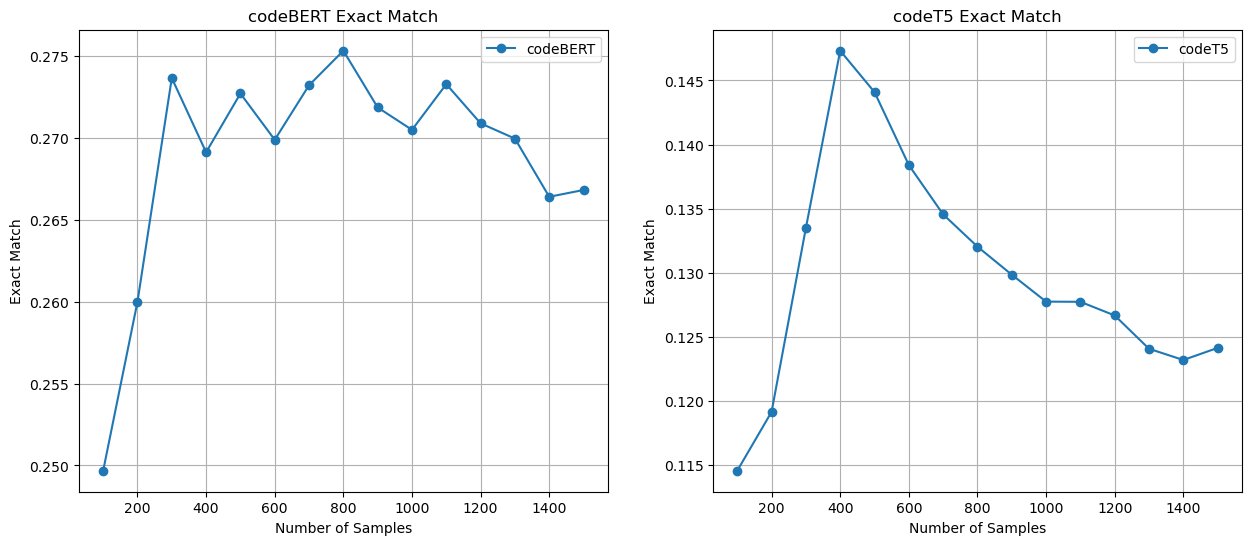

python8.o44770208


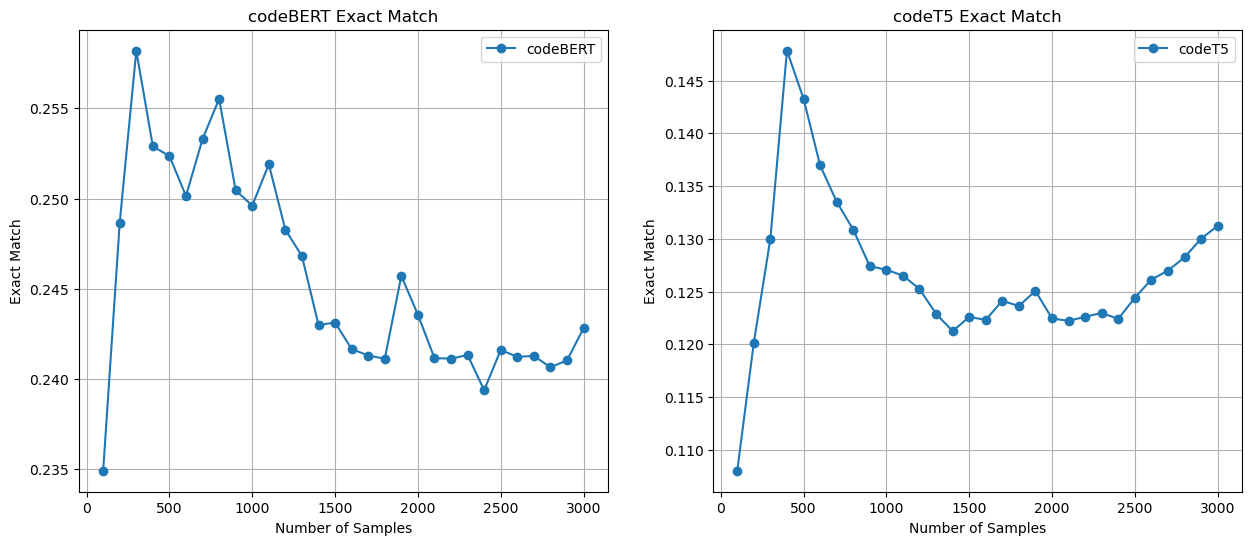

ruby32.o44770279


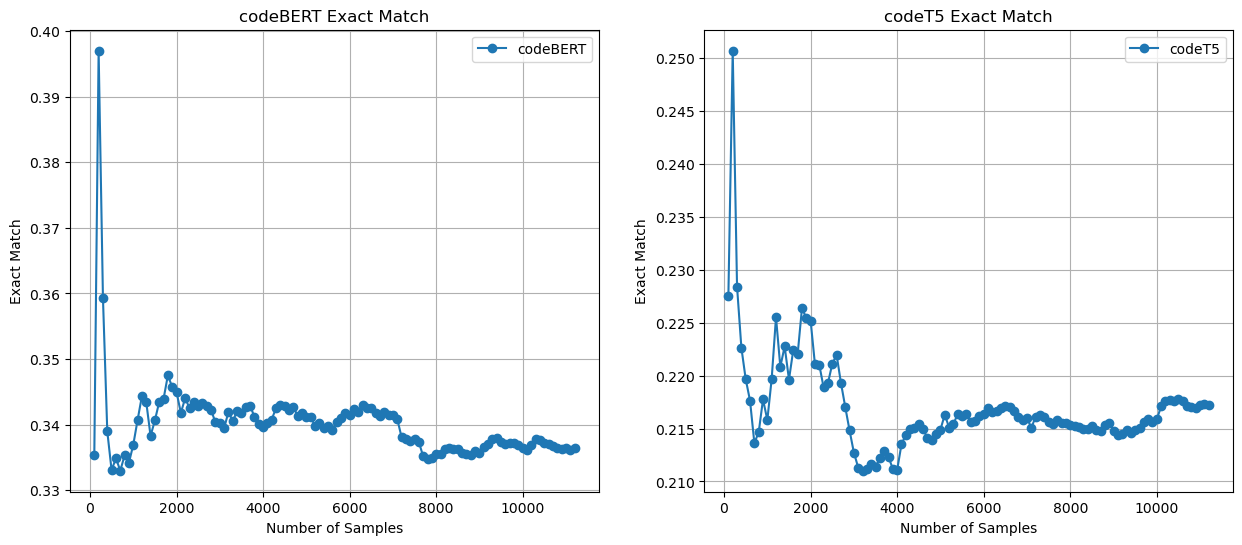

ruby8.o44770278


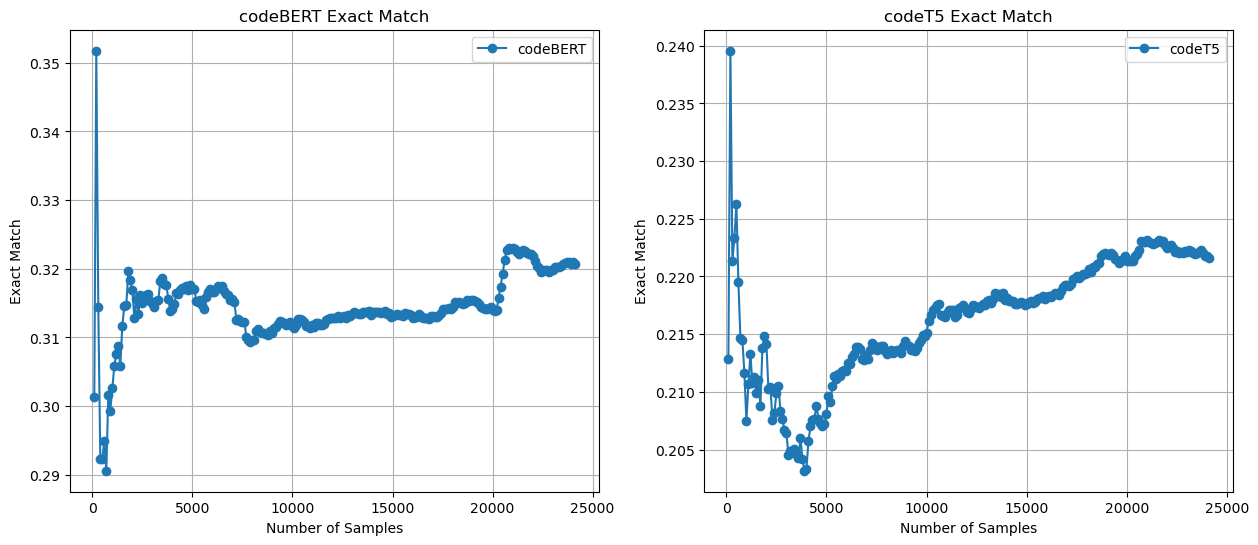

In [24]:
# Load the file

for i in files: 
    with open(i, 'r') as file:
        lines = file.readlines()
    print(i)
    graph(lines)


In [1]:


# Example usage:
cumulative_means = [15,13.125]
values = [5,3]
individual_means = calculate_individual_means(cumulative_means, values)
print(individual_means)


[15.0, 10.0]
